✅ RMSE: 10.508648522654388


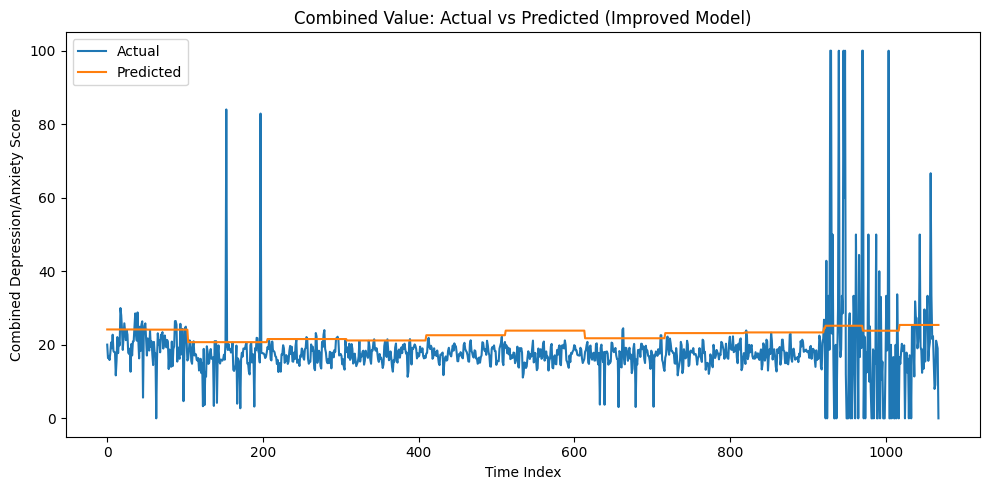

In [2]:
#%%
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#%%
# Load data
trends_df = pd.read_csv("/Users/qibinhuang/Desktop/us_trends_monthly_cleaned.csv")
target_df = pd.read_csv("/Users/qibinhuang/Desktop/combined_depression_anxiety.csv")

#%%
# Process Month_Year columns for merge
trends_df["date"] = pd.to_datetime(trends_df["date"])
trends_df["Month_Year"] = trends_df["date"].dt.to_period("M").astype(str)

target_df["Month"] = target_df["Month"].astype(int).astype(str).str.zfill(2)
target_df["Year"] = target_df["Year"].astype(int).astype(str)
target_df["Month_Year"] = target_df["Year"] + "-" + target_df["Month"]

#%%
# Merge and drop NA
df = pd.merge(trends_df, target_df, on="Month_Year").dropna()

# Add year and month as features
df["year"] = df["Month_Year"].str[:4].astype(int)
df["month"] = df["Month_Year"].str[5:].astype(int)

#%%
# Prepare features and log-transformed target
y = np.log1p(df["Combined_Value"])  # log(1 + y)
X = df.drop(columns=[
    "date", "Month", "Year", "State", "Indicated", "Month_Year", "Combined_Value"
])

#%%
# Time-based split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#%%
# Train XGBoost model with tuned hyperparameters
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

#%%
# Predict and evaluate
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_true = np.expm1(y_test)

rmse = mean_squared_error(y_true, y_pred, squared=False)
print("✅ RMSE:", rmse)

#%%
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_true.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Combined Value: Actual vs Predicted (Improved Model)")
plt.xlabel("Time Index")
plt.ylabel("Combined Depression/Anxiety Score")
plt.legend()
plt.tight_layout()
plt.show()

## This part developed an XGBoost regression model to predict monthly combined depression and anxiety scores in the U.S. using online search trend data. After cleaning and aligning the datasets, engineering time-based features, and applying a log transformation to the target variable, the model achieved a reasonably strong performance with an RMSE of around 10.5.

## The results suggest that search behavior can serve as a meaningful proxy for shifts in population-level mental health. The model was able to follow overall trends and moderate changes in the data, indicating that online search patterns may reflect real-time changes in public emotional states. However, it struggled to fully capture sharp spikes in the target variable, which may be driven by external events or factors not represented in the data.

## These findings support the idea that digital trace data—while imperfect—can complement traditional mental health monitoring tools and provide early signals for broader social and health trends.
